# Imports

In [1]:
import sys
import os
import json
import warnings
import pickle
from dotenv import load_dotenv

!pip install -U google-generativeai
import google.generativeai as genai

from google.colab import drive
from google.colab import files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install papermill
!pip install nbconvert
!pip install nbformat
!pip install IPython

import papermill as pm
import nbformat
from nbconvert import HTMLExporter
from IPython.display import HTML, display

warnings.filterwarnings("ignore")
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: google-generativeai
    Found existing installation: google-generativeai 0.8.5
    Uninstalling google-generativeai-0.8.5:
      Successfully uninstalled google-generativeai-0.8.5


/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.7 MB/s eta 0:00:00


# Bootstrap

In [2]:
np.random.seed(31071967)

load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Mounted at /content/drive


In [3]:
# Define our GOOGLE API KEY  in .env file. GOOGLE_API_KEY=<your api key>
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

In [4]:
def get_best_available_model():
    return "gemini-2.5-flash"

In [5]:
def extract_prediction_params(user_sentence):
    # 1. Dynamically get the model name
    model_name = get_best_available_model()

    if not model_name:
        print("CRITICAL ERROR: No valid Gemini models found for your API key.")
        return None

    print(f"[System] Using model: {model_name}")
    model = genai.GenerativeModel(model_name)

    prompt = f"""
    You are a data extraction assistant.
    Analyze this user request: "{user_sentence}"

    Extract:
    1. "stock_ticker": The ticker symbol (e.g., "Apple" -> "AAPL").
    2. "days": The integer number of days for prediction (e.g., "2 weeks" -> 14).

    Return ONLY raw JSON. Keys: 'stock_ticker', 'days'.
    """

    try:
        # Note: We removed 'response_mime_type' just in case your library version is old.
        # We will handle the JSON manually.
        response = model.generate_content(prompt)

        # Clean up the text to ensure it's valid JSON (remove markdown backticks)
        clean_text = response.text.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_text)
        return data

    except Exception as e:
        print(f"Error extracting data: {e}")
        return None

In [6]:
def get_target_tkl_from_user():

  user_input = input("What would you like to predict and for how long: ") # e.g. "Predict Google for 2 weeks"
  result = extract_prediction_params(user_input)

  while not result or result == None or result.get('stock_ticker') == None:
    print("\nFailed to understand the proment. Please try again.")
    user_input = input("\nRequest: ")
    result = extract_prediction_params(user_input)

  return result

In [7]:
def update_param_in_projet_config_file(param, new_value, file_path=f"{os.getenv('PROJECT_PATH')}/src/config.json"):

    # 1. Check if file exists, if not, create a placeholder
    if not os.path.exists(file_path):
        print(f"[Warning] {file_path} not found. Creating a new one.")
        data = {}
    else:
        # 2. Read the existing data
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
        except json.JSONDecodeError:
            print(f"[Error] {file_path} is empty or corrupted. Starting fresh.")
            data = {}

    # 3. Update the specific variable
    data[param] = new_value

    # 4. Write everything back to the file
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4) # indent=4 makes it readable for humans

    print(f"Successfully updated {param} to: {new_value}")

In [8]:
def run_notebook(notebook_name, output_name, parameters=None):

  # --- Execute the proviuse notebook with parameters ---
  pm.execute_notebook(
      input_path = notebook_name,
      output_path = output_name,
      log_output=False,  # don't print logs while running
      progress_bar=True
  )

  # --- Convert the executed notebook to HTML ---
  nb = nbformat.read(output_name, as_version=4)
  html_exporter = HTMLExporter()
  html_exporter.template_name = "lab"  # modern look; alternatives: 'classic', 'basic'
  body, _ = html_exporter.from_notebook_node(nb)

  # --- Display the HTML result inline ---
  display(HTML(body))

In [9]:
def predict(user_selected_tkl, user_selected_days):

  project_config['TKL'] = user_selected_tkl
  update_param_in_projet_config_file('TKL', user_selected_tkl)
  project_config['PRED.DAYS'] = user_selected_days
  update_param_in_projet_config_file('PRED.DAYS', user_selected_days)

  input_file = f"{os.getenv('PROJECT_PATH')}{project_config['notebooks_directory']}{project_config['notebook9']}"
  output_file = f"{os.getenv('PROJECT_PATH')}{project_config['output_directory']}{project_config['TKL']}.{project_config['output9']}"

  run_notebook(input_file, output_file)

--- Stock Prediction Setup ---
--- Options: Apple, Intel, Microsoft, Nvidia, Teva ---
What would you like to predict and for how long: the Redmond folks, few days
[System] Using model: gemini-2.5-flash
Ticker: MSFT
Days:   3
Pls confirm: [y=yes, n=no] y
Successfully updated TKL to: MSFT
Successfully updated PRED.DAYS to: 3


Executing:   0%|          | 0/10 [00:00<?, ?cell/s]

ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request
ERROR:papermill:unhandled iopub msg: colab_request



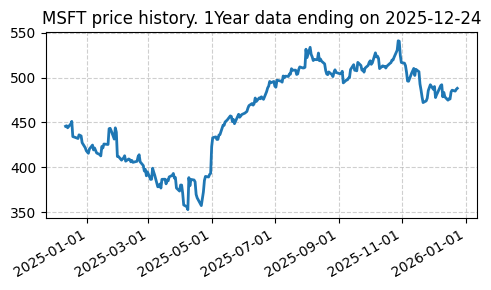

In [10]:
from google.generativeai.client import configure
print("--- Stock Prediction Setup ---")
print("--- Options: Apple, Intel, Microsoft, Nvidia, Teva ---")

confirmed_user_params = False
while not confirmed_user_params:

  result = get_target_tkl_from_user()
  days = int(result.get('days')) if result.get('days') != None else int(project_config["PRED.DAYS"])

  print(f"Ticker: {result.get('stock_ticker')}")
  print(f"Days:   {days}")

  if days < 1 or days > 10:
    print("Days should be between 1 and 10")
    confirmed_user_params = False
    continue

  confirmed_user_params = (input("Pls confirm: [y=yes, n=no] ") == 'y')
  if result.get('stock_ticker') not in ['AAPL', 'INTC','MSFT','NVDA', 'TEVA']:
    print("Stocks currently supprted ")
    print("Options: Apple, Intel, Microsoft, Nvidia, Teva")
    confirmed_user_params = False
    continue

  else:
    predict(result.get('stock_ticker'), days)
    break